In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import pandas as pd
import csv
import datetime
import math

from __future__ import print_function
import os
from functools import partial
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

# Helper functions for TF Graph visualization (imported).
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [2]:
# Set theme.
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
from jupyterthemes import jtplot

set_nb_theme('onedork')
jtplot.style()

In [3]:
# Load all.
print('Reading data.')
fundamentals_reader = csv.reader(open("fundamentals.csv", "rt"), delimiter=",")
fundamentals = list(fundamentals_reader)
prices_reader = csv.reader(open("prices.csv", "rt"), delimiter=",")
prices = list(prices_reader)

# Delete titles.
fundamentals_titles = fundamentals[0]
prices_titles = prices[0]
del fundamentals[0]
del prices[0]

# We want to pull the price at the day of the fundamental release into the fundamentals list.
fundamental_dict = {}
print('Building fundamentals dictionary.')
for item in fundamentals:
    ticker = item[1]
    date = item[2][:7] # first same month
    identifier = (date, ticker)
    
    assert len(item) == 79
    assert fundamental_dict.get(identifier) is None
    fundamental_dict[identifier] = item
    
print('Assigning prices to fundamentals dictionary.')
for item in prices:
    ticker = item[1]
    date = item[0][:7] # first same month
    identifier = (date, ticker)
    
    existing = fundamental_dict.get(identifier)
    if existing is not None:
        existing.append(float(item[3]))
        del fundamental_dict[identifier]

# Check that all have been covered.
print(len(fundamental_dict), 'entries not covered. \nTickers: ', set(item[1] for item in fundamental_dict.keys()))

print(len(fundamentals), 'pre-curation.')

# ... discard these.
fundamentals = [e for e in fundamentals if fundamental_dict.get((e[2][:7], e[1])) is None]
        
print(len(fundamentals), 'curated items.')

Reading data.
Building fundamentals dictionary.
Assigning prices to fundamentals dictionary.
33 entries not covered. 
Tickers:  {'PSX', 'COTY', 'HPE', 'ILMN', 'XYL', 'HCA', 'WRK', 'PYPL', 'MPC', 'SYF', 'UA', 'CFG', 'WLTW', 'NAVI', 'FBHS', 'CSRA', 'ABBV', 'QRVO', 'TRIP'}
1781 pre-curation.
1748 curated items.


In [4]:
# We're going to use all our data points for now.
# Let's calculate our labels.
prior_prices = {}

print('Building price index for fundamentals.')
for item in fundamentals:
    ticker = item[1]
    date_string = item[2][:7] # first same month
    date = datetime.date(int(date_string[:4]), int(date_string[5:7]), 1)
    price = item[79]
    
    ticker_list = prior_prices.get(ticker)
    if not ticker_list:
        ticker_list = []
        prior_prices[ticker] = ticker_list
        
    ticker_list.append((date, item))
    
# Sort each entry in order of date.
print('Sorting price index for fundamentals.')
for item in prior_prices.values():
    item.sort(key=lambda e: e[0])
    
# Obtain price deltas.
print('Obtaining price deltas.')
for ticker_list in prior_prices.values():
    if len(ticker_list) > 1:
        for i in range(len(ticker_list) - 1):
            date_delta = ticker_list[i + 1][0] - ticker_list[i][0]
            price_delta = ticker_list[i + 1][1][79] - ticker_list[i][1][79]

            ticker_list[i][1].append(date_delta)
            ticker_list[i][1].append(price_delta)     

# Remove endpoints.
print(len(fundamentals), 'pre-curation data points.')
fundamentals = [e for e in fundamentals if len(e) == 82]

# the rest is just bookkeeping
removed_items = 0
items_within_one_quarter = 0
items_within_one_year = 0
items_greater_than_one_year = 0
for item in fundamentals:
    if item[80].days < 65:
        items_within_one_quarter += 1
    elif item[80].days <= 365:
        items_within_one_year += 1
    else:
        items_greater_than_one_year += 1

print(len(fundamentals), 'data points obtained.')
print(removed_items, 'data points removed.')
print(items_within_one_quarter, 'data points within the same quarter.')
print(items_within_one_year, 'data points within the same year.')
print(items_greater_than_one_year, 'data points from within more than one year.')

assert items_within_one_quarter + items_within_one_year + items_greater_than_one_year == len(fundamentals)

Building price index for fundamentals.
Sorting price index for fundamentals.
Obtaining price deltas.
1748 pre-curation data points.
1303 data points obtained.
0 data points removed.
0 data points within the same quarter.
1109 data points within the same year.
194 data points from within more than one year.


In [5]:
# Now we have our training/testing set.
# use data points within one year.
year_constrained_data_points = [e for e in fundamentals if e[80].days <= 365]

data_list = [e[3:79] for e in year_constrained_data_points]
target_list = [e[81] for e in year_constrained_data_points]

# We need to get rid of null columns. We can't use these.
null_columns = set()
for row in data_list:
    for i, element in enumerate(row):
        try:
            float(element)
        except:
            null_columns.add(i)

print('Invalid columns:', null_columns)
print('Or,', [e for i, e in enumerate(fundamentals_titles) if i - 3 in null_columns])
print('Removing.')

data_list = [[e for i, e in enumerate(row) if i not in null_columns] for row in data_list]

Invalid columns: {6, 73, 74, 11, 75, 58}
Or, ['Cash Ratio', 'Current Ratio', 'Quick Ratio', 'For Year', 'Earnings Per Share', 'Estimated Shares Outstanding']
Removing.


In [11]:
binary_labels = [float(e > 0) for e in target_list]

In [18]:
# We finally have our dataset!
data = np.array(data_list).astype('float')
target = np.array(binary_labels).astype('float')
target = np.expand_dims(target, -1)

In [19]:
# Normalize
data_norm = data / np.linalg.norm(data, axis=0)

# print for debug
print('Data:')
print(data_norm)
print('Target:')
print(target)

Data:
[[ 0.00579782 -0.01259786 -0.0723005  ...,  0.00220892  0.01575228
  -0.00073116]
 [ 0.00940162 -0.00527748 -0.10039483 ...,  0.00552466  0.01694883  0.        ]
 [ 0.00882146 -0.00907954 -0.00553038 ...,  0.00564841  0.02703016  0.        ]
 ..., 
 [ 0.          0.         -0.0016378  ...,  0.00747575  0.00149672  0.        ]
 [ 0.00260978 -0.00561797  0.00033182 ...,  0.00085696  0.00289061  0.        ]
 [ 0.00202395  0.00391555 -0.00025808 ...,  0.00086088  0.00303257  0.        ]]
Target:
[[ 1.]
 [ 1.]
 [ 0.]
 ..., 
 [ 1.]
 [ 1.]
 [ 1.]]


In [20]:
# seperate data
TRAIN_FRAC = 0.7
VALID_FRAC = 0.1

trainDimEnd = math.floor(data_norm.shape[0] * TRAIN_FRAC)
validDimEnd = math.floor(data_norm.shape[0] * (TRAIN_FRAC + VALID_FRAC))

trainData = data_norm[:trainDimEnd]
trainTarget = target[:trainDimEnd]
validData = data_norm[trainDimEnd:validDimEnd]
validTarget = target[trainDimEnd:validDimEnd]
testData = data_norm[validDimEnd:]
testTarget = target[validDimEnd:]

# print for debug
print('Train Dimensions:')
print(trainData.shape)
print(trainTarget.shape)
print('Valid Dimensions:')
print(validData.shape)
print(validTarget.shape)
print('Test Dimensions:')
print(testData.shape)
print(testTarget.shape)

Train Dimensions:
(776, 70)
(776, 1)
Valid Dimensions:
(111, 70)
(111, 1)
Test Dimensions:
(222, 70)
(222, 1)


In [21]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

def neural_net_block(prev_layer, layer_size):
    PREV_LAYER_DIM = prev_layer.get_shape().as_list()[1]
    XAVIER_INIT_STDDEV = tf.cast(3 / (layer_size + PREV_LAYER_DIM), tf.float32)

    # initialize variables
    layer_weights = tf.Variable(tf.random_normal([PREV_LAYER_DIM, layer_size], stddev=XAVIER_INIT_STDDEV), name='weights')
    layer_biases = tf.Variable(tf.zeros([1, layer_size]), name='bias')

    # calculate output
    layer_z = tf.matmul(prev_layer, layer_weights) + layer_biases
    
    # return all in order to have external handle for variables
    return layer_z, layer_weights, layer_biases

Epoch 1000 / 1000 : 0.135667 loss


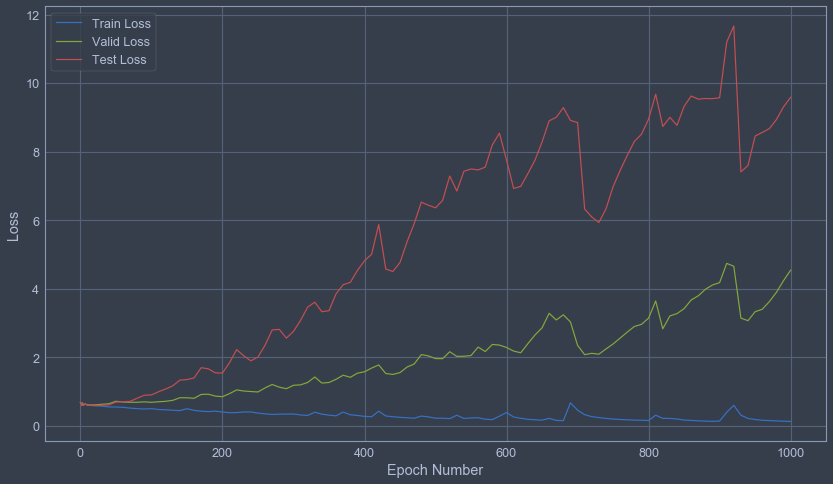

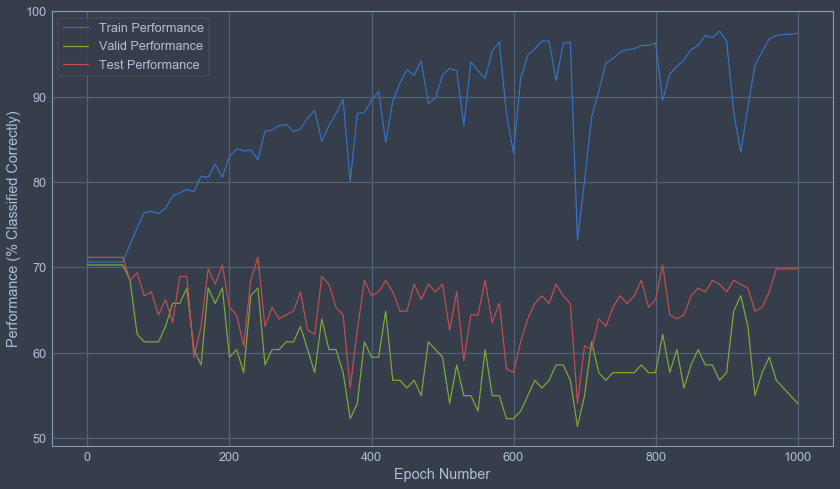

Epoch 1000 / 1000 : Model saved in file  .\model-2.2.2-v2.ckpt


In [22]:
# parameters
MAX_NUM_EPOCHS = 1000
PRINT_FREQUENCY = 0.01
SAVE_FREQUENCY = 0.25
η = 0.01
λ = 0.0003
input_shape = [None, 70]
label_shape = [None, 1]
tf.set_random_seed(7)

# profiles
train_loss_profile = []
valid_loss_profile = []
test_loss_profile = []
train_performance_profile = []
valid_performance_profile = []
test_performance_profile = []
epoch_profile = []

# reset for graph visualization
# tf.reset_default_graph()

# placeholders
x = tf.placeholder(tf.float32, shape=input_shape, name='x')
y = tf.placeholder(tf.float32, shape=label_shape, name='y')

# prediction
z_1, W_1, b_1 = neural_net_block(x, 500)
z_2, W_2, b_2 = neural_net_block(tf.nn.relu(z_1), 300)
z_3, W_3, b_3 = neural_net_block(tf.nn.relu(z_2), 300)
z_4, W_4, b_4 = neural_net_block(tf.nn.relu(z_3), label_shape[1])
y_hat = z_4
y_hat_out = tf.sigmoid(y_hat)

# loss
cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y_hat, y)) \
                                    + (λ / 2) * (tf.reduce_sum(tf.square(W_1)) + tf.reduce_sum(tf.square(W_2)))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=η)
train = optimizer.minimize(loss=cross_entropy_loss)

# init
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
                         
# begin training
for epoch in range(MAX_NUM_EPOCHS + 1):
    train_res = sess.run(train, feed_dict={x:trainData, y:trainTarget})

    # print progress periodically
    if epoch % (MAX_NUM_EPOCHS * PRINT_FREQUENCY) == 0 or epoch < 10:
        # check overall loss 
        train_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:trainData, y:trainTarget}))
        valid_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:validData, y:validTarget}))
        test_loss_profile.append(sess.run(cross_entropy_loss, feed_dict={x:testData, y:testTarget}))

        # check overall performance
        train_y_hat = sess.run(y_hat_out, feed_dict={x:trainData, y:trainTarget})
        train_performance_profile.append(np.sum(np.all(np.rint(train_y_hat) == trainTarget, axis=1)) / trainTarget.shape[0] * 100)
        valid_y_hat = sess.run(y_hat_out, feed_dict={x:validData, y:validTarget})
        valid_performance_profile.append(np.sum(np.all(np.rint(valid_y_hat) == validTarget, axis=1)) / validTarget.shape[0] * 100)
        test_y_hat = sess.run(y_hat_out, feed_dict={x:testData, y:testTarget})
        test_performance_profile.append(np.sum(np.all(np.rint(test_y_hat) == testTarget, axis=1)) / testTarget.shape[0] * 100)
        
        # append epoch profile
        epoch_profile.append(epoch)
        
        # clear plot
        clear_output(wait=True)
        print('Epoch', epoch, '/', MAX_NUM_EPOCHS, ':', train_loss_profile[-1], 'loss')
        
        # plot losses
        plt.figure(figsize=(14, 8))
        plt.plot(epoch_profile, train_loss_profile, label='Train Loss')
        plt.plot(epoch_profile, valid_loss_profile, label='Valid Loss')
        plt.plot(epoch_profile, test_loss_profile, label='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch Number')
        plt.legend()
        plt.savefig('2.2.2-Loss.png')
        plt.show()
        
        # plot performance
        plt.figure(figsize=(14, 8))
        plt.plot(epoch_profile, train_performance_profile, label='Train Performance')
        plt.plot(epoch_profile, valid_performance_profile, label='Valid Performance')
        plt.plot(epoch_profile, test_performance_profile, label='Test Performance')
        plt.ylabel('Performance (% Classified Correctly)')
        plt.xlabel('Epoch Number')
        plt.legend()
        plt.savefig('2.2.2-Performance.png')
        plt.show()
        
    # save progress periodically
    if epoch % round(MAX_NUM_EPOCHS * SAVE_FREQUENCY) == 0:
        save_path = saver.save(sess, ".\model-2.2.2-v2.ckpt")
        print('Epoch', epoch, '/', MAX_NUM_EPOCHS, ': Model saved in file ', save_path)